<a href="https://colab.research.google.com/github/Aryanupadhyay23/Deep-Learning-/blob/main/train_yolo11_object_detection_on_custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to Train YOLO11 Object Detection on a Custom Dataset

---

YOLO11 builds on the advancements introduced in YOLOv9 and YOLOv10 earlier this year, incorporating improved architectural designs, enhanced feature extraction techniques, and optimized training methods.

YOLO11m achieves a higher mean mAP score on the COCO dataset while using 22% fewer parameters than YOLOv8m, making it computationally lighter without sacrificing performance.

YOLOv11 is available in 5 different sizes, ranging from `2.6M` to `56.9M` parameters, and capable of achieving from `39.5` to `54.7` mAP on the COCO dataset.

## Setup

### Configure API keys

To fine-tune YOLO11, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [4]:
!nvidia-smi

Sun Mar  1 10:10:18 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8             11W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [5]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLO11 via Ultralytics

In [3]:
%pip install "ultralytics<=8.3.40" supervision roboflow
# prevent ultralytics from tracking your activity
!yolo settings sync=False
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 43.6/112.6 GB disk)


## Inference with model pre-trained on COCO dataset

### CLI

**NOTE:** CLI requires no customization or Python code. You can simply run all tasks from the terminal with the yolo command.

In [ ]:
!yolo task=detect mode=predict model=yolo11n.pt conf=0.25 source='https://media.roboflow.com/notebooks/examples/dog.jpeg' save=True

100% 5.35M/5.35M [00:00<00:00, 95.9MB/s]
WARNING ⚠️ yolo11n.pt appears to require 'dill', which is not in Ultralytics requirements.
AutoInstall will run now for 'dill' but this feature will be removed in the future.
Recommend fixes are to train a new model using the latest 'ultralytics' package or to run a command with an official Ultralytics model, i.e. 'yolo predict model=yolov8n.pt'
requirements: Ultralytics requirement ['dill'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 5.0 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 2.3s, installed 1 package: ['dill']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

Ultralytics 8.3.2 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

100% 104k/104k [00:00<00:00, 44.7MB/s]
image 1/1 /content/dog.jpeg: 640x384 2 persons, 1 car, 1 dog, 1 handbag, 61.4ms
Speed: 11.7ms 

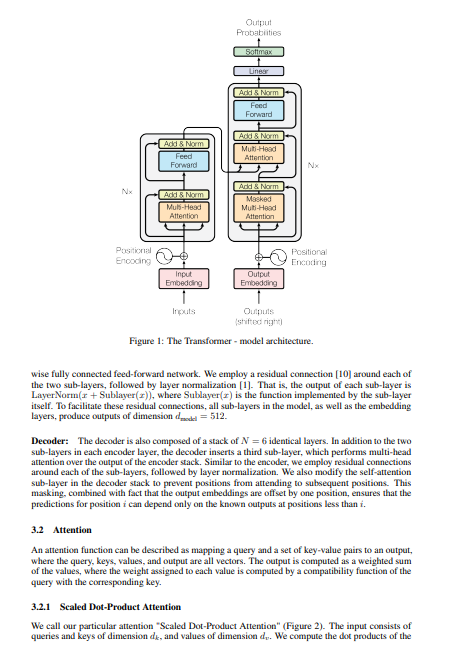

In [12]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/Screenshot 2026-03-01 154548.png', width=600)

In [46]:
from ultralytics import YOLO
from PIL import Image
import requests

model = YOLO('yolo11n.pt')
image = Image.open('/content/dog.jfif')
result = model.predict(image, conf=0.25)[0]


0: 640x640 1 dog, 8.1ms
Speed: 2.1ms preprocess, 8.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


**NOTE:** The obtained `result` object stores information about the location, classes, and confidence levels of the detected objects.

In [47]:
result.boxes.xyxy

tensor([[ 26.0507,  14.4847, 191.3615, 224.9149]], device='cuda:0')

In [48]:
result.boxes.conf

tensor([0.9205], device='cuda:0')

In [49]:
result.boxes.cls

tensor([16.], device='cuda:0')

**NOTE:** YOLO11 can be easily integrated with `supervision` using the familiar `from_ultralytics` connector.

In [50]:
import supervision as sv

detections = sv.Detections.from_ultralytics(result)

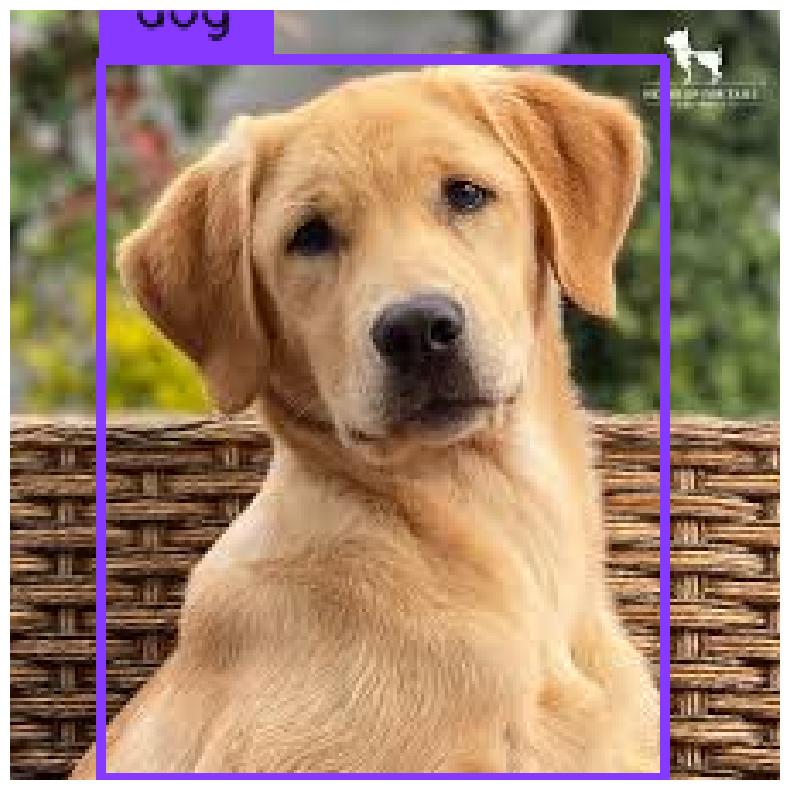

In [51]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK)

annotated_image = image.copy()
annotated_image = box_annotator.annotate(annotated_image, detections=detections)
annotated_image = label_annotator.annotate(annotated_image, detections=detections)

sv.plot_image(annotated_image, size=(10, 10))

## Fine-tune YOLO11 on custom dataset

In [56]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

from google.colab import userdata
from roboflow import Roboflow

ROBOFLOW_API_KEY = userdata.get('roboflow_key')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

workspace = rf.workspace("huyifei")
project = workspace.project("tft-id")
version = project.version(1)
dataset = version.download("yolov11")

mkdir: cannot create directory ‘/content/datasets’: File exists
/content/datasets
loading Roboflow workspace...
loading Roboflow project...


## Custom Training

In [57]:
dataset.location

'/content/datasets/TFT-ID-1'

In [58]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11n.pt data={dataset.location}/data.yaml epochs=10 imgsz=640 plots=True

/content
New https://pypi.org/project/ultralytics/8.4.19 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/datasets/TFT-ID-1/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show

In [59]:
!ls {HOME}/runs/detect/train/

args.yaml					    results.png
confusion_matrix_normalized.png			    train_batch0.jpg
confusion_matrix.png				    train_batch1.jpg
events.out.tfevents.1772361791.5244567ef3cb.9366.0  train_batch2.jpg
F1_curve.png					    val_batch0_labels.jpg
labels_correlogram.jpg				    val_batch0_pred.jpg
labels.jpg					    val_batch1_labels.jpg
P_curve.png					    val_batch1_pred.jpg
PR_curve.png					    val_batch2_labels.jpg
R_curve.png					    val_batch2_pred.jpg
results.csv					    weights


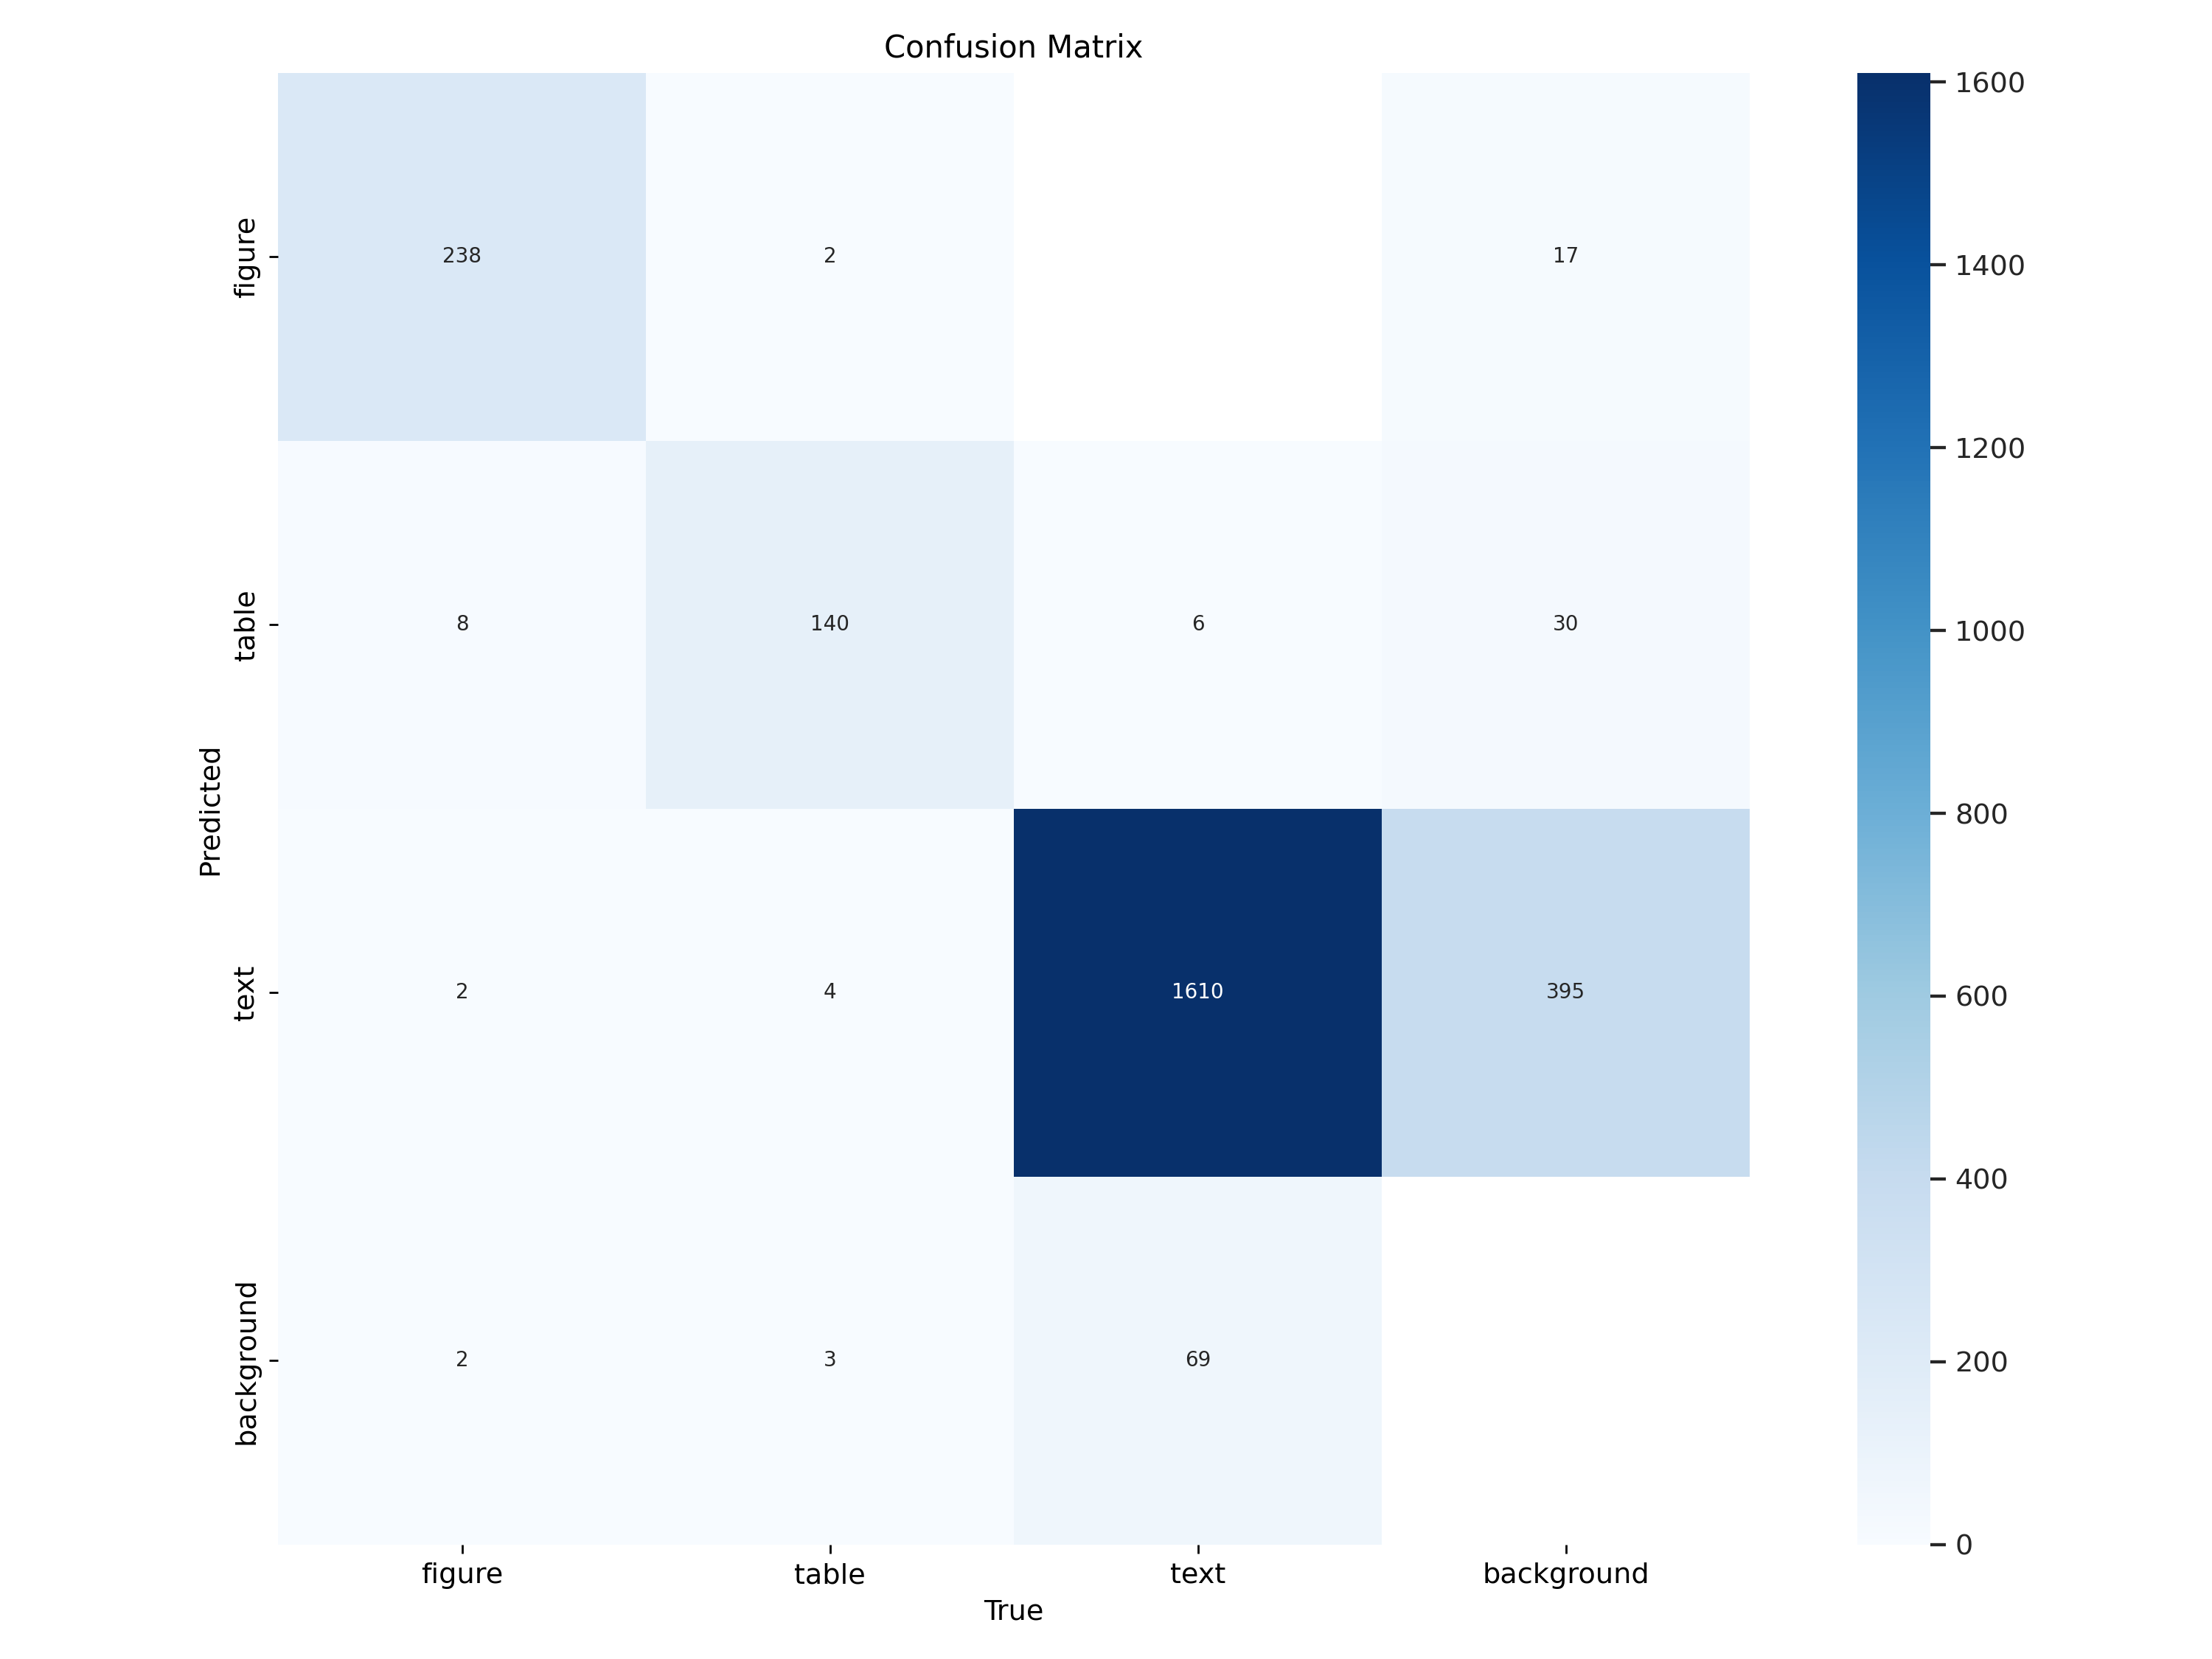

In [60]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

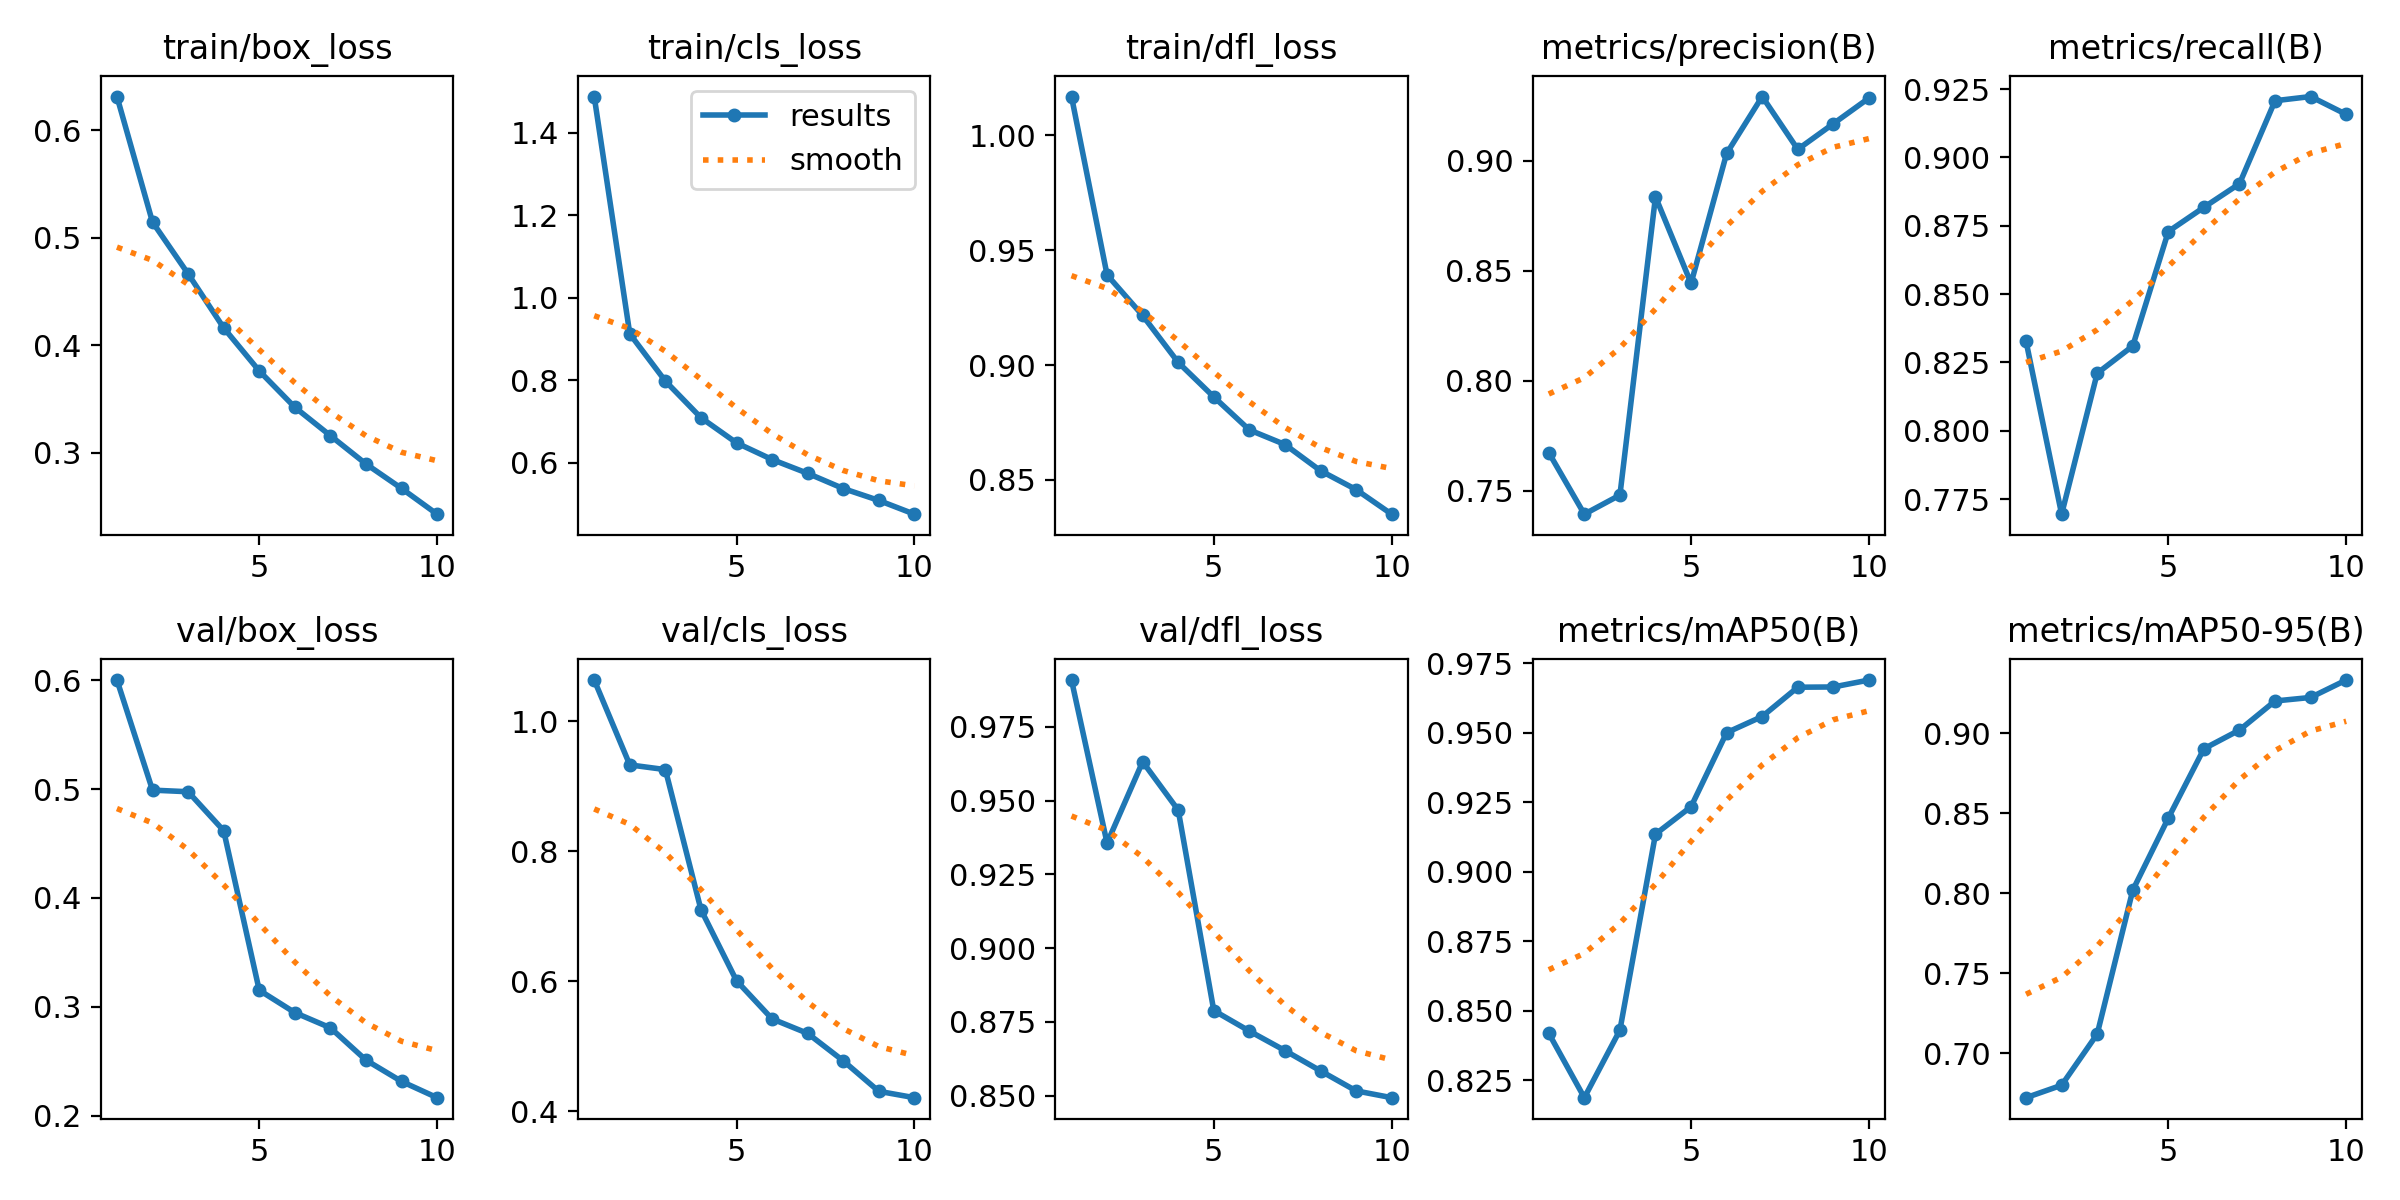

In [61]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

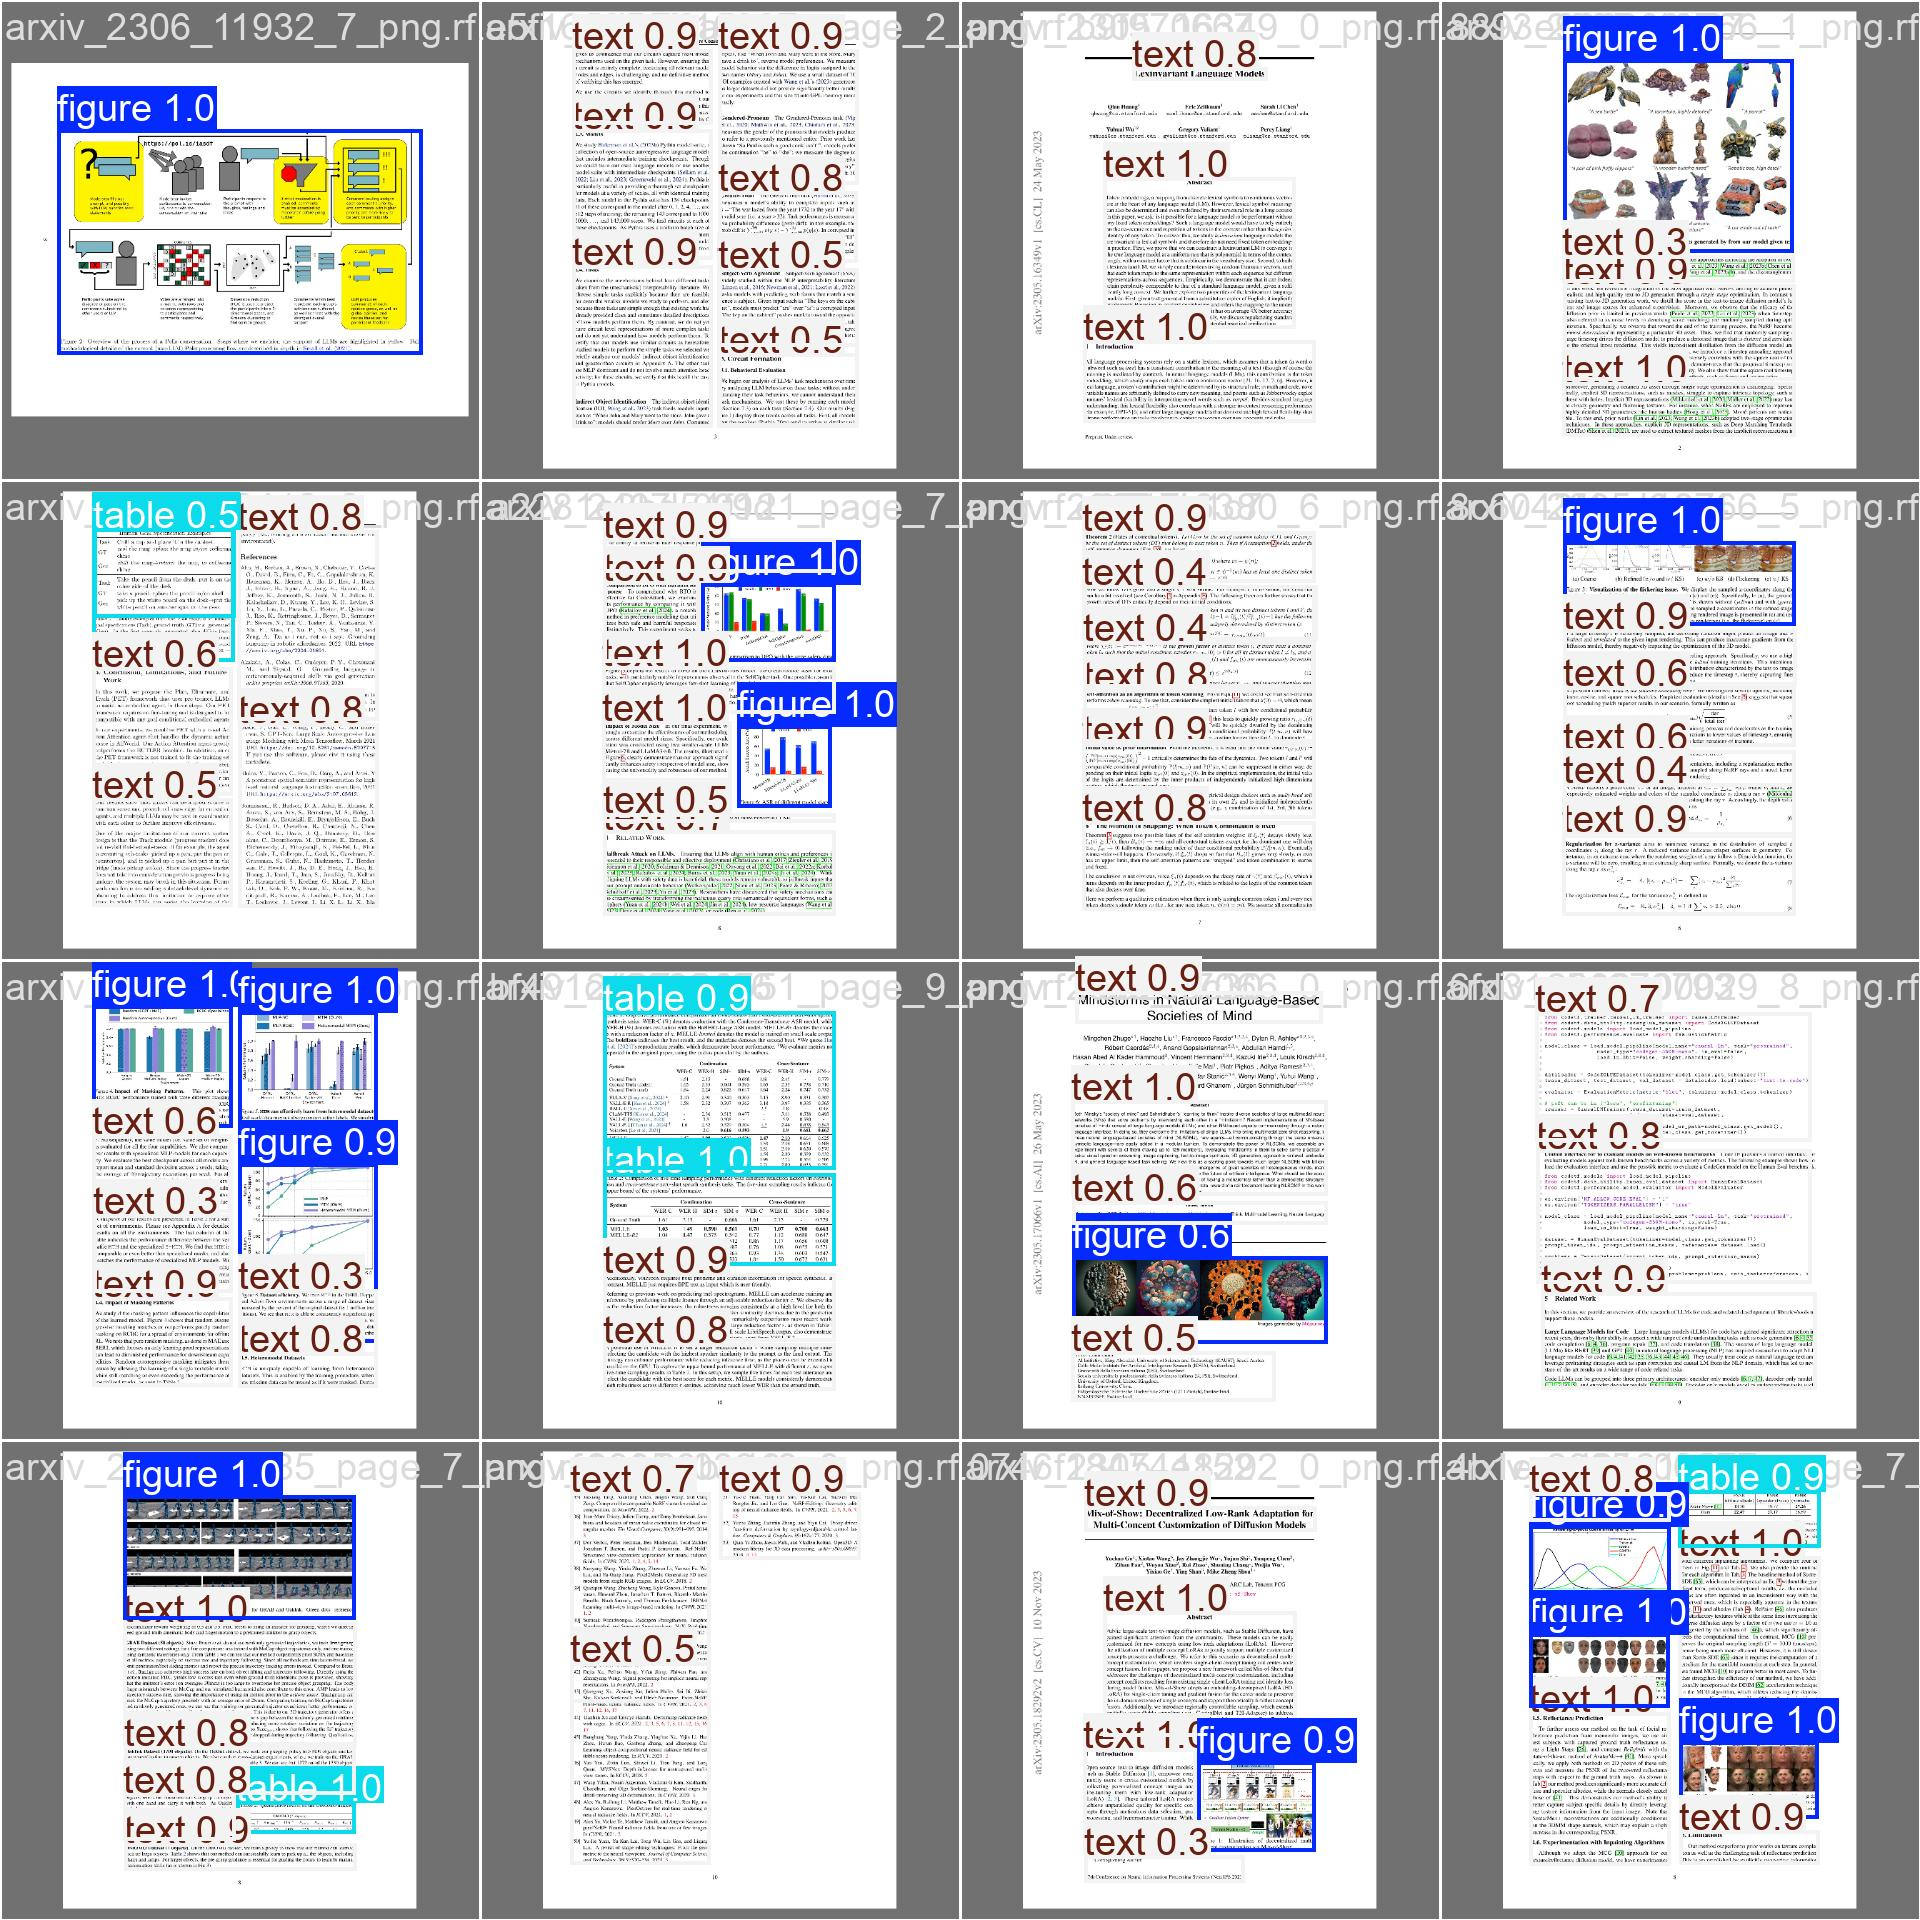

In [62]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [63]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
YOLO11n summary (fused): 238 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs
val: Scanning /content/datasets/TFT-ID-1/valid/labels.cache... 431 images, 2 backgrounds, 0 corrupt: 100% 431/431 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 27/27 [00:08<00:00,  3.05it/s]
                   all        431       2084      0.929      0.916      0.969      0.934
                figure        196        250      0.974      0.944      0.987      0.969
                 table        106        149      0.877      0.946      0.956      0.936
                  text        422       1685      0.937      0.857      0.964      0.897
Speed: 1.1ms preprocess, 4.9ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


## Inference with custom model

In [64]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
YOLO11n summary (fused): 238 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs

image 1/430 /content/datasets/TFT-ID-1/test/images/arxiv_2305_02412_3_png.rf.32f6409a183be4b92c631c71a6d780b9.jpg: 640x512 2 figures, 1 table, 4 texts, 46.9ms
image 2/430 /content/datasets/TFT-ID-1/test/images/arxiv_2305_02412_7_png.rf.7b62359e54e4d3351b4b13cc753c08ec.jpg: 640x512 1 figure, 2 tables, 4 texts, 7.6ms
image 3/430 /content/datasets/TFT-ID-1/test/images/arxiv_2305_02665_4_png.rf.815a85a442d156cdad1178f7f6952bd4.jpg: 640x480 1 figure, 4 texts, 47.5ms
image 4/430 /content/datasets/TFT-ID-1/test/images/arxiv_2305_02968_3_png.rf.36f288a156a4db6c10e060bdd912bdf2.jpg: 640x512 1 figure, 7 texts, 8.5ms
image 5/430 /content/datasets/TFT-ID-1/test/images/arxiv_2305_03689_0_png.rf.772b06c466575a3872bd3ff29c72b9bd.jpg: 640x512 3 texts, 7.7ms
image 6/430 /content/datasets/TFT-ID-1/test/images/arxiv_2305_03981_7_png.rf.c9f6

**NOTE:** Let's take a look at few results.

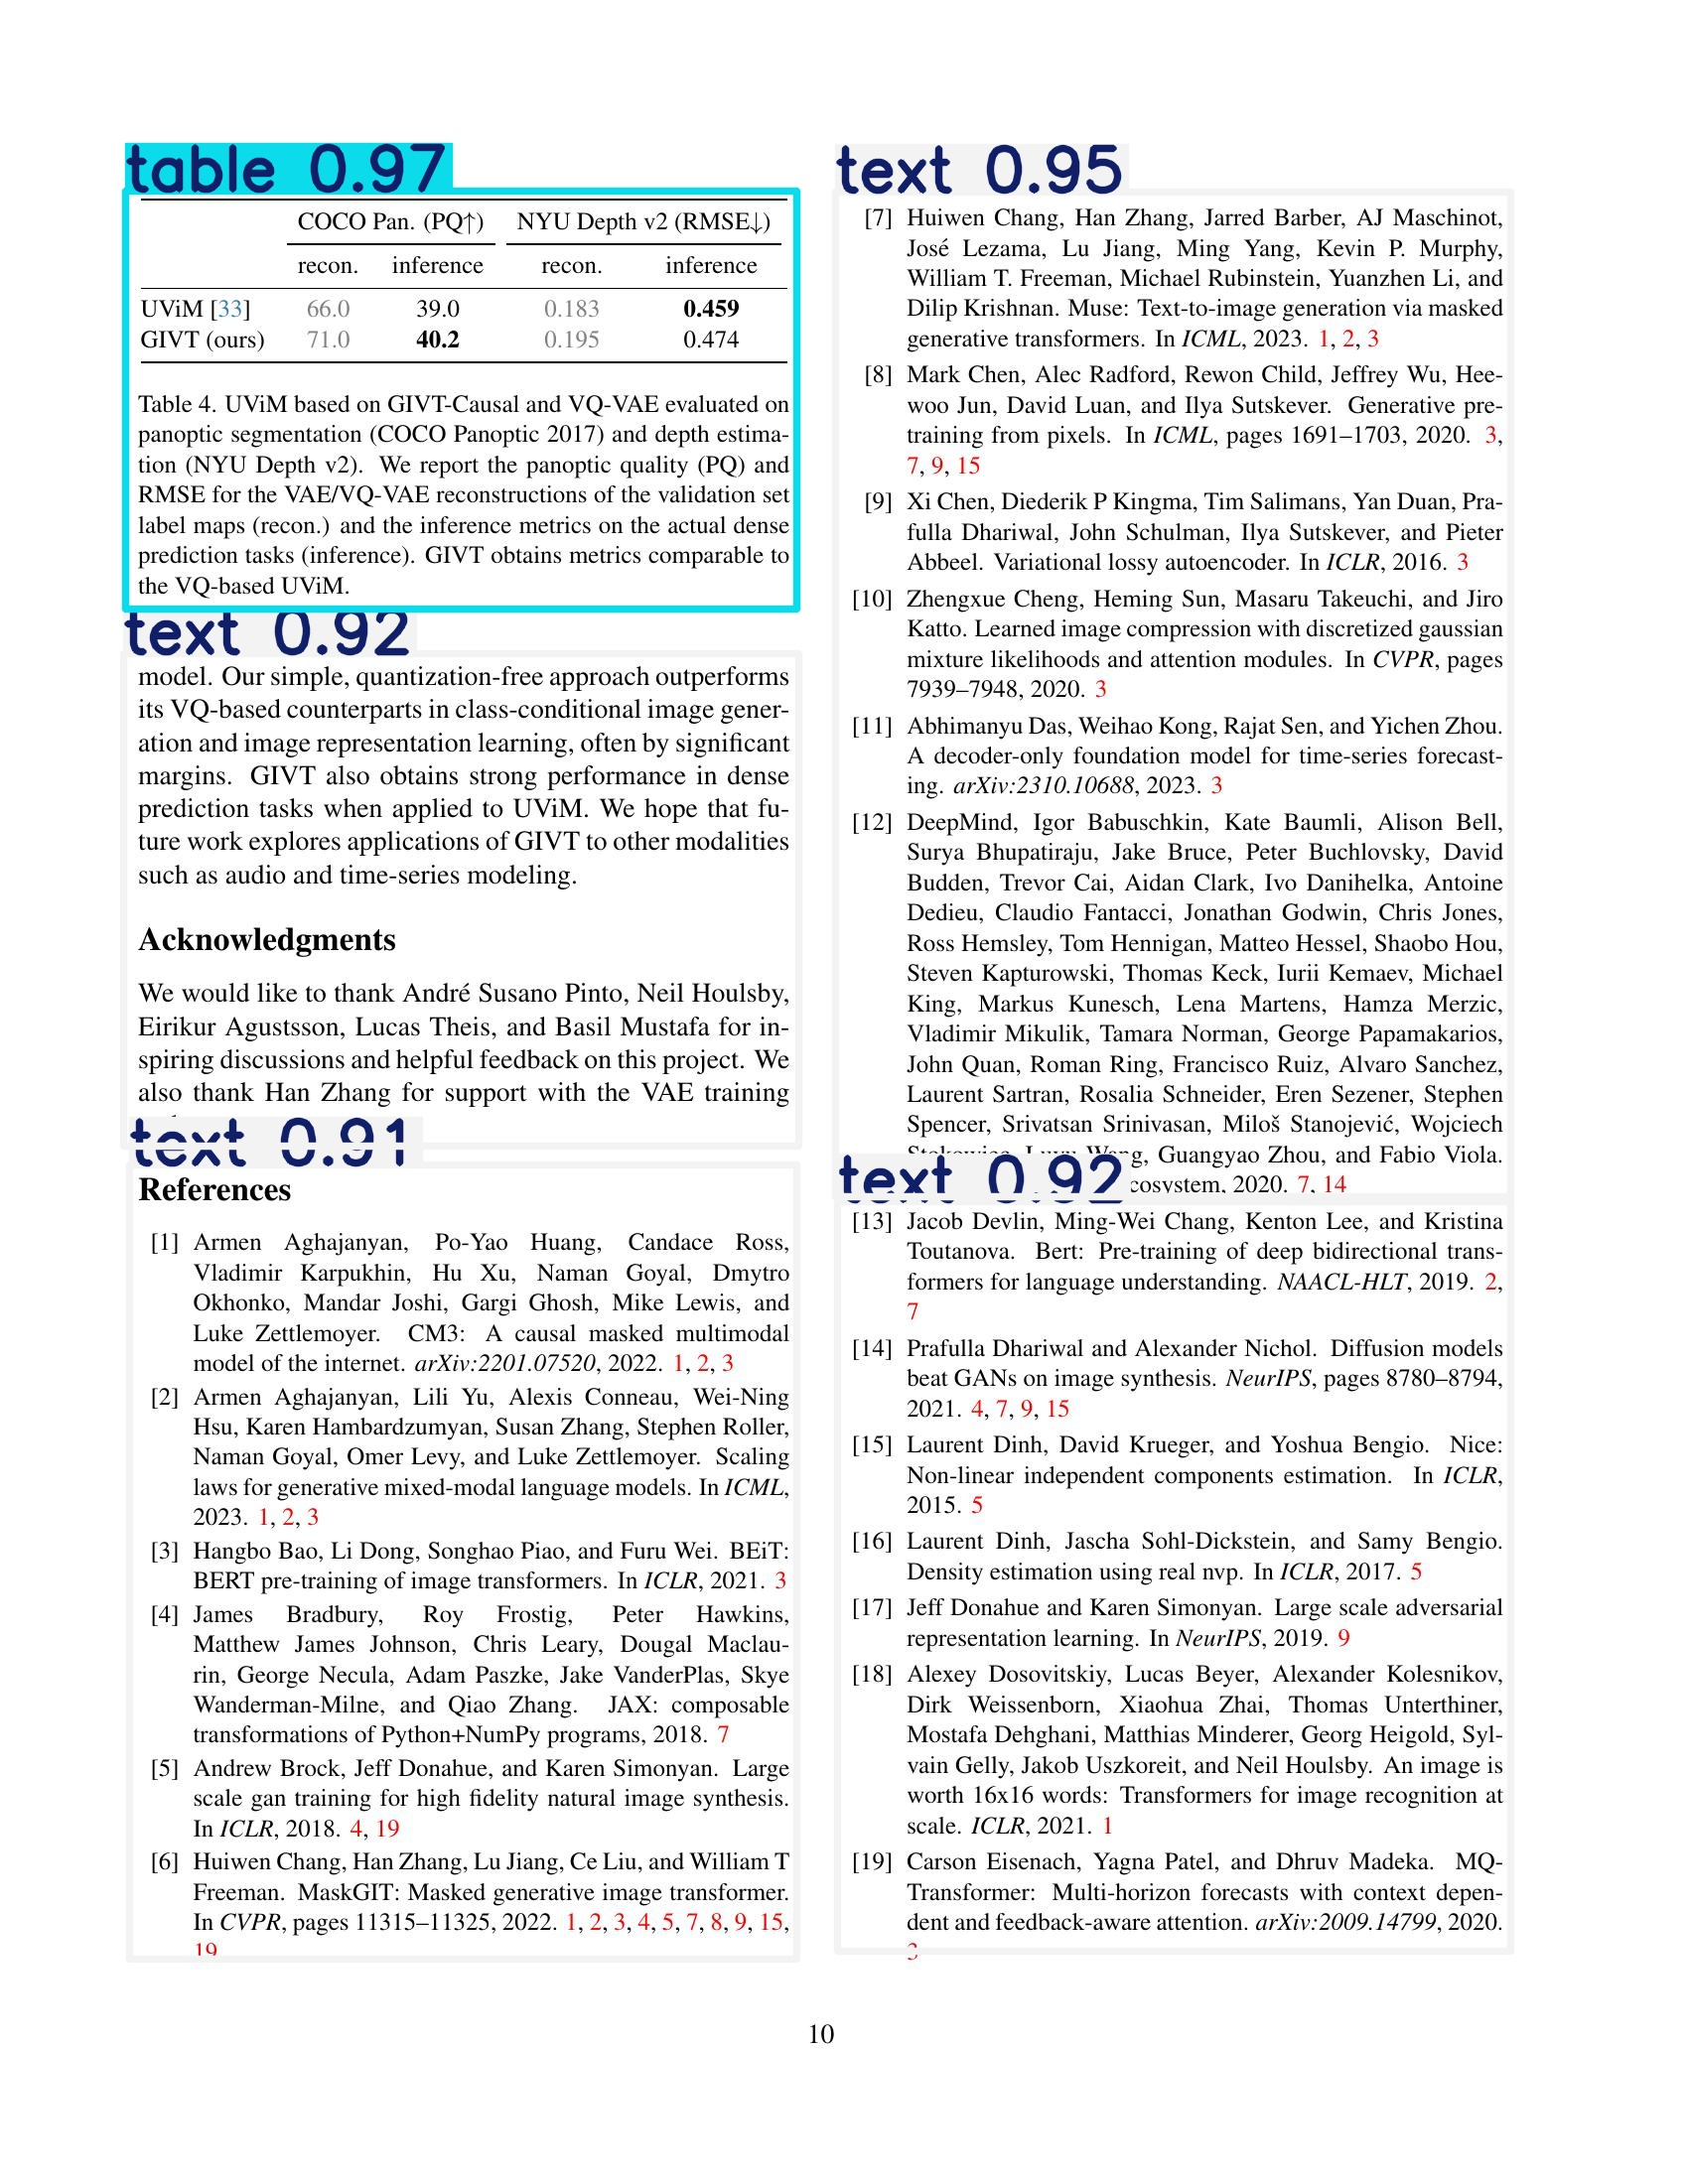

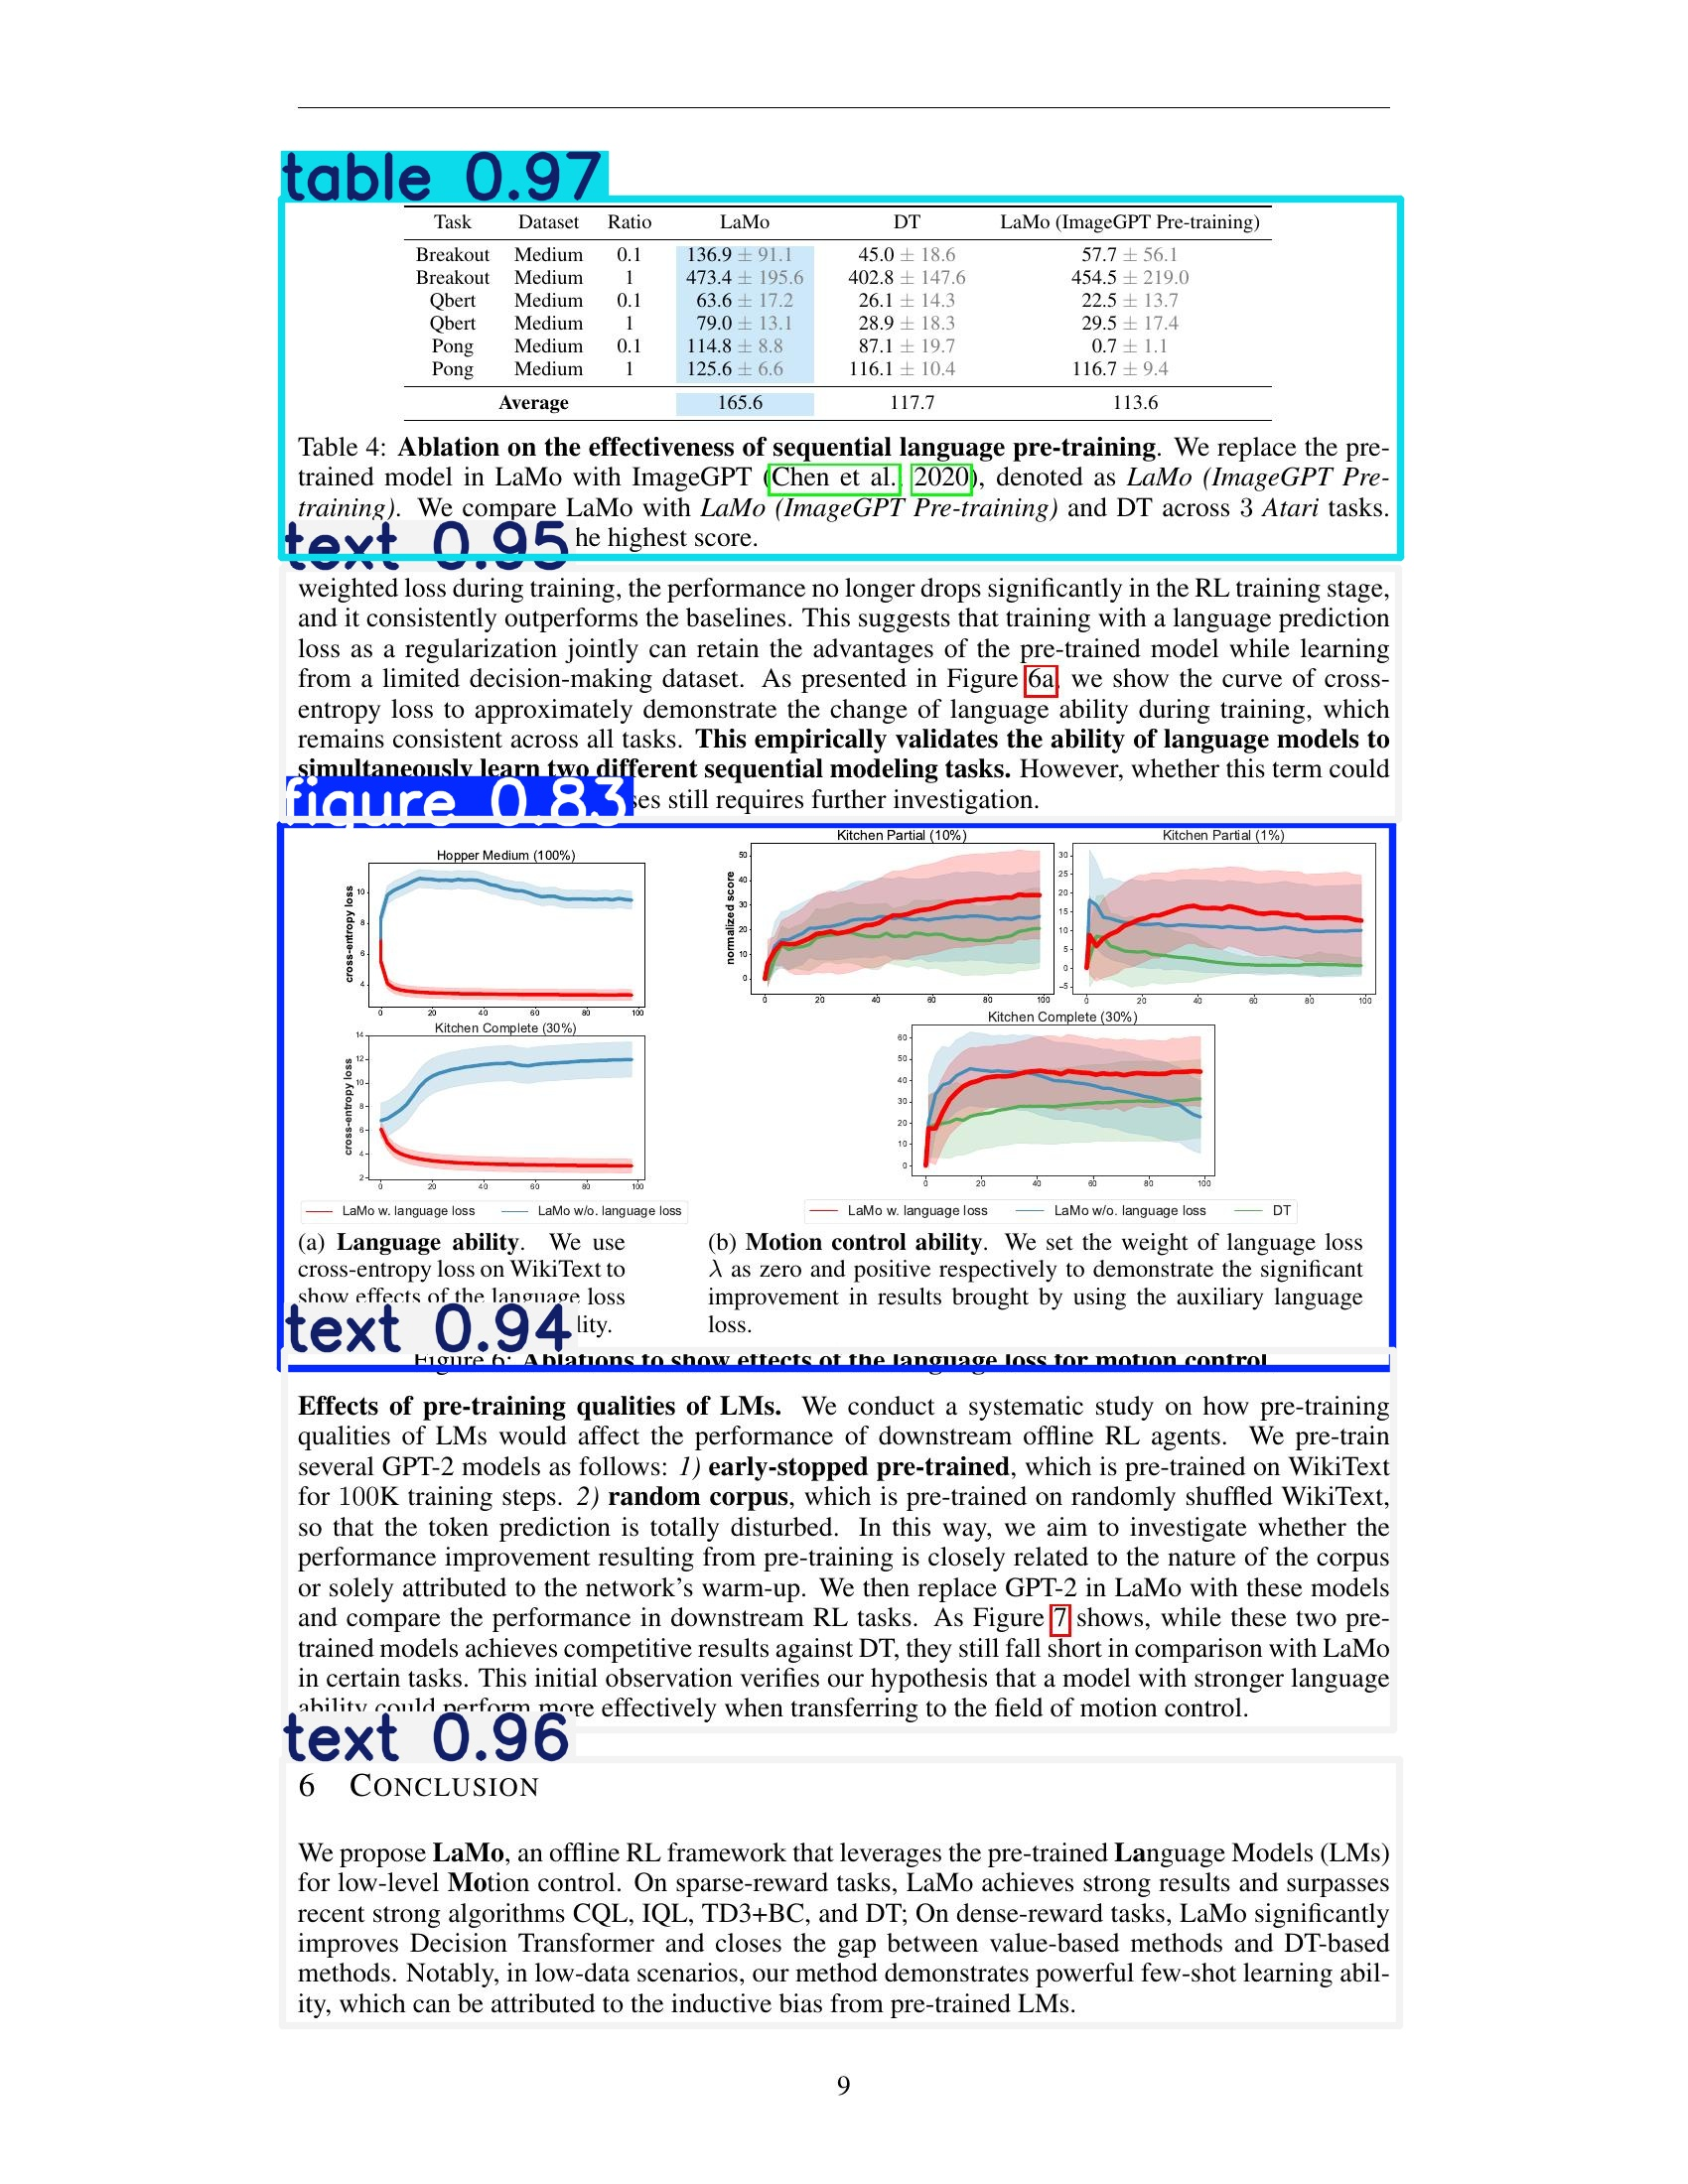

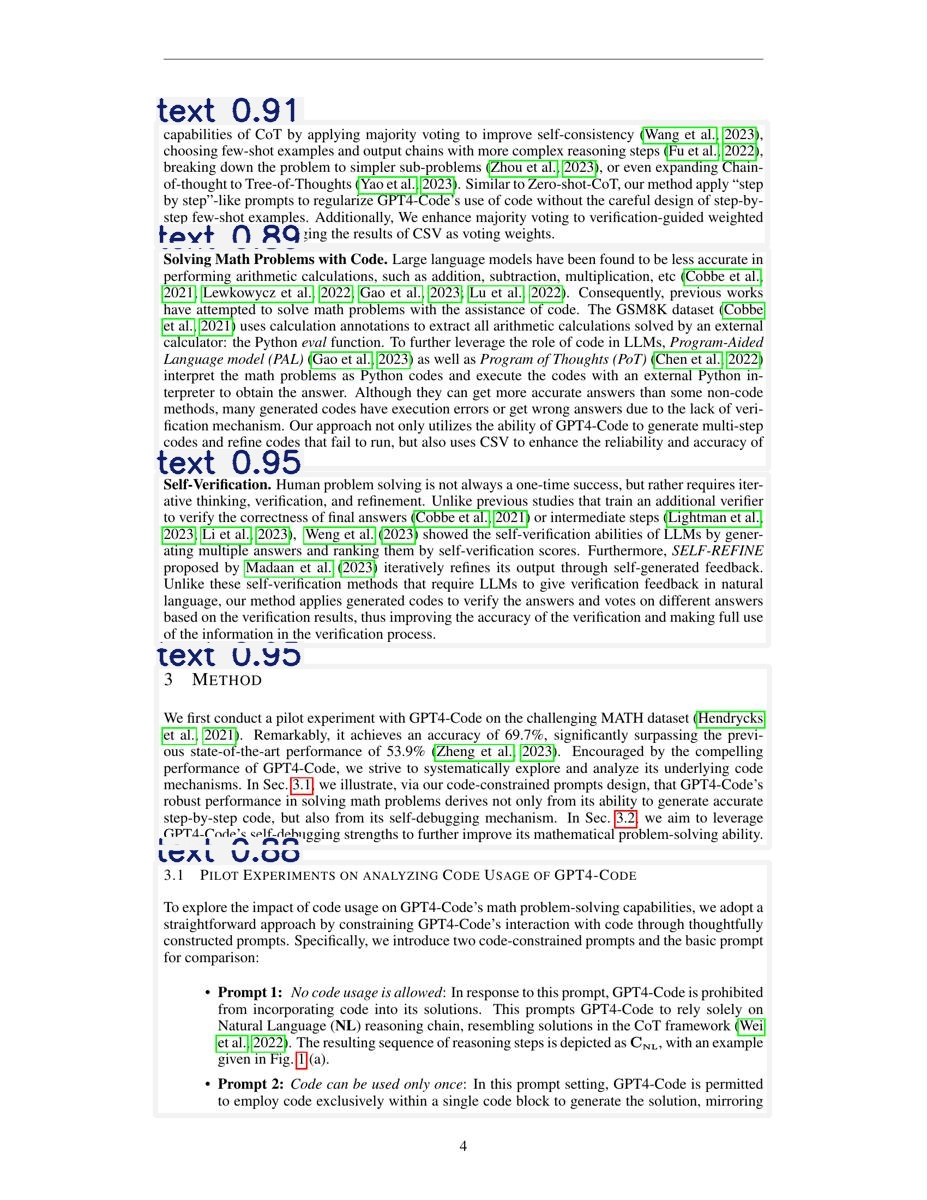

In [65]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'{HOME}/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")


0: 640x448 1 figure, 2 texts, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)


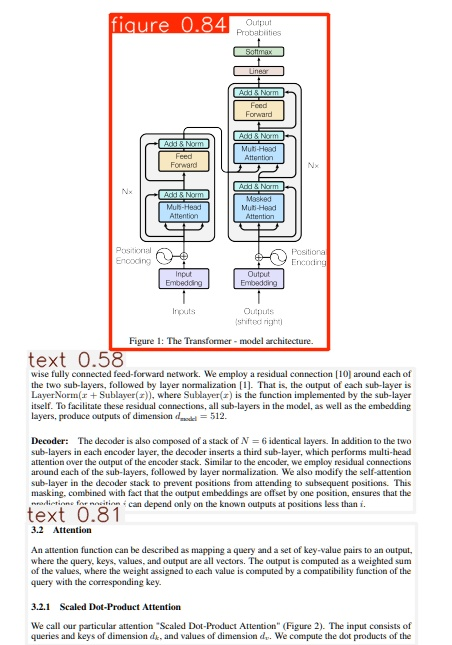

In [72]:
import os
import cv2
from ultralytics import YOLO
from IPython.display import display, Image

model_path = "/content/runs/detect/train/weights/best.pt"   # <-- Change if needed
model = YOLO(model_path)

image_path = "/content/Screenshot 2026-03-01 154548.png"   # <-- PUT YOUR IMAGE PATH HERE

# Check if file exists
if not os.path.exists(image_path):
    raise FileNotFoundError(f"Image not found at: {image_path}")

image = cv2.imread(image_path)

if image is None:
    raise ValueError("Failed to read image. Check the file format.")

results = model(image, conf=0.4)[0]

predicted_image = results.plot()

# Convert BGR → RGB for correct notebook display
predicted_image = cv2.cvtColor(predicted_image, cv2.COLOR_BGR2RGB)

_, buffer = cv2.imencode(".jpg", predicted_image)
display(Image(data=buffer.tobytes()))